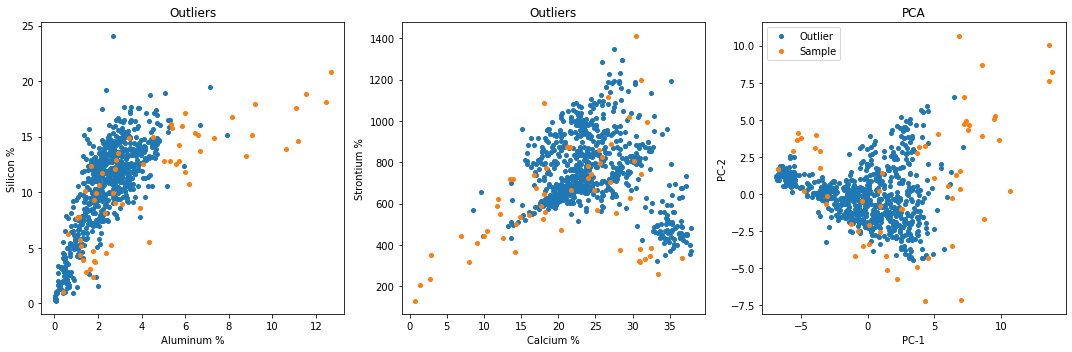

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #dataframe features

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#from adjustText import adjust_text ##need to incorporate this from Github

#%reset how else do you clear variables?
#import csv files from core. A lot of room for improvement here.
dataimport = r'C:\Users\Esben Pedersen\Documents\UT Austin\MS Thesis\Geochem\Github\Core-chemofacies-clustering\RandomCore.csv'
LOD_T5 = r'C:\Users\larsont\Desktop\Coredatabase\T5iLOD.csv'
#convert imported files to dataframes. The idea is to not change the original files
coredata = pd.read_csv(dataimport)
LODT5=pd.read_csv(LOD_T5)
coredata.sort_values(by=['Depth_calculated']) #sorts coredata by depth
elements = ['Na', 'Mg', 'Al', 'Si', 'P', 'S', 'K', 'Ca', 'Ti','Mn', 'Fe', 'Ba', 'V', 'Cr', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'As', 'Pb','Se', 'Th', 'Rb', 'U', 'Sr', 'Y', 'Zr', 'Nb', 'Mo']

coredata[elements]=np.maximum(coredata[elements],LODT5) #add LOD to each element

# vector of the outlier values for each element
Element_outlier=(coredata[elements]).mean()+4*(coredata[elements]).std()#toggle 3 or 4 to decide if enough outliers are selected
coredata['Outliers']=((coredata[elements])>Element_outlier).any(axis='columns') #makes a new column based on above conditional format


fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,5))
plt.subplot(1, 3, 1)
groups = coredata.groupby("Outliers")
for name, group in groups:
    plt.plot(group["Al"], group["Si"], marker="o",  ms=4, linestyle="", label=name)
plt.title('Outliers')
plt.xlabel('Aluminum %')
plt.ylabel('Silicon %')
plt.tight_layout()

plt.subplot(1, 3,2)
groups = coredata.groupby("Outliers")
for name, group in groups:
    plt.plot(group["Ca"], group["Sr"], marker="o",  ms=4, linestyle="", label=name)
plt.title('Outliers')
plt.xlabel('Calcium %')
plt.ylabel('Strontium %')
plt.tight_layout()


#Principal Component Analysis
pca = decomposition.PCA(n_components=len(elements))#toggle n_components
# Centered (mean = zero X - X.mean(axis=0)) and with unit variance
X=coredata 
y = coredata.Outliers.values
X = X[elements].values
X_centered = StandardScaler().fit(X).transform(X)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

plt.subplot(1, 3, 3)
plt.plot(X_pca[y == False, 0], X_pca[y == False, 1],marker="o", label='Outlier', ms=4, linestyle="")
plt.plot(X_pca[y == True, 0], X_pca[y == True, 1], marker="o", label='Sample', ms=4, linestyle="")

plt.title('PCA')
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.legend()
plt.tight_layout()



In [13]:
X=(coredata[coredata['Outliers'] == False]) #excludes outliers
#X=coredata 

x = X[elements].values #all elements
#y = coredata.Outliers.

# In general, it's a good idea to scale the data prior to PCA.

scaler = StandardScaler() #create a standard scaler object
pca = PCA() #create a PCA object called pca. could include pca = PCA(n_components=1)

scaler.fit(x)
#X=scaler.transform(X)    
x_new = pca.fit_transform(scaler.transform(x))
#print(scaler.transform(X))
features= np.arange(len(elements))

#Call the function. Use only the 2 PCs.
#myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
#plt.show()

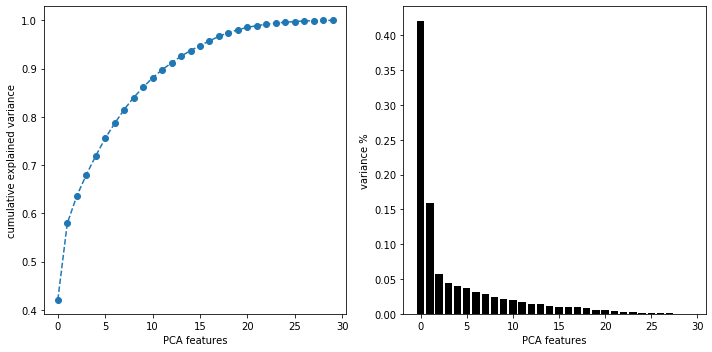

In [14]:
fig, ((ax4, ax5)) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
plt.subplot(1, 2, 1)

plt.plot(pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.ylabel('cumulative explained variance')
plt.xlabel('PCA features')
plt.subplot(1, 2, 2)
plt.bar(features,pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.tight_layout()

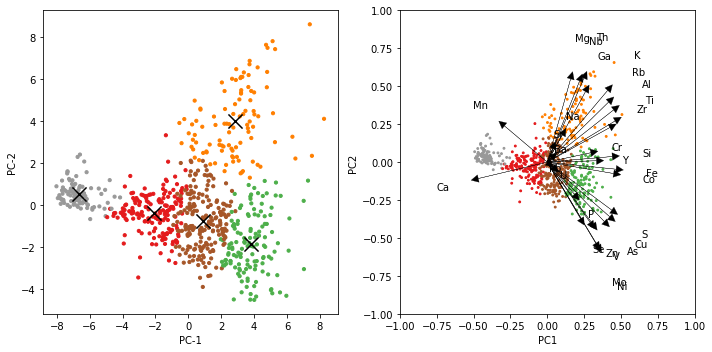

<Figure size 432x288 with 0 Axes>

In [15]:
#### select the number of clusters and number of PC's used in the clustering. 
#Esben added computations that optimize the number of PC's and the number of cluster.
clusters=5
Principal_components=5

x_cluster = x_new[:, np.arange(Principal_components)] #select the PCAs to use for clustering.
kmeans = KMeans(n_clusters=clusters)#select the number of clusters
kmeans.fit(x_cluster) #results from PCA
y_kmeans = kmeans.predict(x_cluster)

def myplot(score,coeff,labels=elements): #Esben puts labels = None 
    
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    plt.scatter(xs * scalex,ys * scaley,s=3.5,c=y_kmeans,cmap='Set1') #clustered. c='tab:blue' to not cluster
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*2, coeff[i,1]*2, color = 'k', linewidth = 0.25,alpha = None,length_includes_head=True,
                  head_width=0.05, head_length=0.05) #I added multipliers to increase lenght of vector
        plt.text(coeff[i,0]* 2.75, coeff[i,1] * 2.75, labels[i], color = 'k', ha = 'center', va = 'center')    
    
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    #plt.grid()


fig, ((ax6, ax7)) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(x_cluster[:, 0], x_cluster[:, 1], c=y_kmeans, s=10, cmap='Set1')
centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1],marker='x', c='black', s=200);
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.tight_layout()

plt.subplot(1, 2, 2)
#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.tight_layout()
#adjust_text(texts, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5)) #this will adjust text

plt.show()
plt.tight_layout()

In [7]:
Chemofacies=y_kmeans
X['Chemofacies']=Chemofacies #makes a new column based on above conditional format

Y=(coredata[coredata['Outliers'] == True]) #excludes outliers
Y["Chemofacies"] = np.nan

Z=pd.concat([X, Y], ignore_index=True)

Z.to_csv (r'C:\Users\larsont\Desktop\Coredatabase\Z.csv', index = False, header=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\larsont\\Desktop\\Coredatabase\\Z.csv'

In [ ]:
%reset